# MLNet Image Classifier for the MSL Dataset
This is a model for images captured by the Left Mastcam on the Curiosity rover.

There are three parts:
1. Prepare Hardware and Data
2. Building and Training
3. Evaluation and Predictions

-Riley Knybel 7/16/2023

## Part 1/3: Prepare Hardware and Data

In [1]:
#import tensorflow and other libraries
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import os
img_folder = "ml-images"

2023-07-26 23:22:22.355075: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 23:22:22.989982: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Tensorflow GPU memory allocation fix
#https://github.com/tensorflow/tensorflow/issues/35264
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2023-07-26 23:22:26.992718: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 23:22:26.997541: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 23:22:26.997700: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
#count the images in the dataset
count = 0
cpt = sum([len(files) for r, d, files in os.walk(img_folder)])
print(str(cpt) + " total images in dataset")

1882 total images in dataset


In [4]:
#load the dataset using Keras

#SPLIT
#Train/Validate/Test
#70%/15%/15%

batch_size = 4
img_height = 227
img_width = 227

#training/validation split
train_ds = tf.keras.utils.image_dataset_from_directory(
    img_folder,
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_and_test = tf.keras.utils.image_dataset_from_directory(
  img_folder,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds, test_ds = tf.keras.utils.split_dataset(val_and_test, left_size=0.5)

val_size = len(val_ds) * batch_size
test_size = len(test_ds) * batch_size

print("True validation size: " + str(val_size))
print("True test size: " + str(test_size))

Found 1882 files belonging to 14 classes.
Using 1318 files for training.
Found 1882 files belonging to 14 classes.
Using 564 files for validation.


2023-07-26 23:22:29.981144: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 23:22:29.981435: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 23:22:29.981552: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

True validation size: 284
True test size: 284


In [5]:
# show class names
class_names = train_ds.class_names
print(class_names)

['chemcam cal target', 'drill\n', 'ground', 'horizon', 'inlet', 'mahli', 'mastcam cal target', 'observation tray', 'portion tube', 'rems uv sensor', 'rover rear deck', 'scoop', 'turret', 'wheel']


In [6]:
#normalize data - change pixel scale from 0-255 to 0-1
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 0.8718106


## Part 2/3: Building and Training

In [7]:
#alexnet
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(img_height, img_width,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(15, activation='softmax')
])

In [8]:
#compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [9]:
#see the layers!
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (Batch  (None, 55, 55, 96)        384       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Bat  (None, 27, 27, 256)       1024      
 chNormalization)                                                
                                                        

In [10]:
#set training parameters
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.0001)


In [11]:
#train the model, time to cook!

#repeat is used to make sure there is enough training data for 3000 iterations

epochs=6
steps_per_epoch=500
history = model.fit(
  train_ds.repeat(9),
  validation_data=val_ds.repeat(9),
  epochs=epochs,
  steps_per_epoch=steps_per_epoch
)

Epoch 1/6


/home/riley/.local/lib/python3.10/site-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-07-26 23:23:15.019587: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2023-07-26 23:23:15.206357: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-26 23:23:15.209171: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55c285558240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-26 23:23:15.209205: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-07-26 23:23:15.215076: I ten

500/500 [==============================] - 19s 29ms/step - loss: 3.1445 - accuracy: 0.6862 - val_loss: 2.1671 - val_accuracy: 0.6950
Epoch 2/6
500/500 [==============================] - 14s 28ms/step - loss: 1.8937 - accuracy: 0.7796 - val_loss: 1.9542 - val_accuracy: 0.7837
Epoch 3/6
500/500 [==============================] - 14s 27ms/step - loss: 1.1209 - accuracy: 0.8654 - val_loss: 0.7454 - val_accuracy: 0.8936
Epoch 4/6
500/500 [==============================] - 14s 27ms/step - loss: 0.8811 - accuracy: 0.8652 - val_loss: 1.4165 - val_accuracy: 0.8262
Epoch 5/6
500/500 [==============================] - 14s 27ms/step - loss: 0.6104 - accuracy: 0.9044 - val_loss: 0.5210 - val_accuracy: 0.9184
Epoch 6/6
469/500 [===========================>..] - ETA: 0s - loss: 0.5174 - accuracy: 0.9152WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 3000 batches). You

2023-07-26 23:24:35.939802: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 12363047502450933858
2023-07-26 23:24:35.939840: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 3177820058501861876
2023-07-26 23:24:35.939846: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 7089893128253210546


500/500 [==============================] - 13s 27ms/step - loss: 0.5169 - accuracy: 0.9152 - val_loss: 1.5834 - val_accuracy: 0.8404


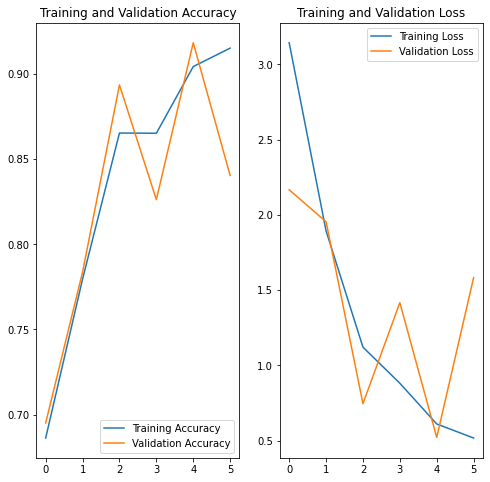

In [12]:
#visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Part 3/3: Evaluation and Predictions

In [13]:
#evaluate the accuracy
score = model.evaluate(val_ds, verbose=0)
print("Validation Loss: " + str(score[0]))
print("Validation Accuracy: " + str(score[1]))

score = model.evaluate(test_ds, verbose=0)
print("Test Loss: " + str(score[0]))
print("Test Accuracy: " + str(score[1]))

Validation Loss: 1.583384394645691
Validation Accuracy: 0.8404255509376526
Test Loss: 1.502774715423584
Test Accuracy: 0.8510638475418091


In [ ]:
# generate the confusion matrix

# predict on the validation dataset
validation_predictions = model.predict(validation_generator)
# Convert predicted probabilities to class labels
predicted_labels = np.argmax(validation_predictions, axis=1)

from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(validation_generator.classes, predicted_labels)

In [ ]:
# visualize the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()